In [2]:
import time
import random
import subprocess
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from pycoral.utils.edgetpu import make_interpreter
from pycoral.adapters import classify
from pycoral.adapters import common

import tflite_runtime.interpreter as tflite
from imgaug import augmenters as img_aug

from lane_navigation.image_augmentation import random_augment


In [10]:
def my_imread(image_path):
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    return image


def img_preprocess(image):
    height, _, _ = image.shape
    image = image[
        int(height / 2) :, :, :
    ]  # remove top half of the image, as it is not relavant for lane following
    image = cv2.cvtColor(
        image, cv2.COLOR_RGB2YUV
    )  # Nvidia model said it is best to use YUV color space
    image = cv2.GaussianBlur(image, (3, 3), 0)
    image = cv2.resize(image, (200, 66))  # input image size (200,66) Nvidia model
    image = (
        image / 255
    )  # normalizing, the processed image becomes black for some reason.  do we need this?
    # image = image.astype(np.uint8)
    return image


def image_data_generator(image_paths, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering_angles = []

        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            if is_training:
                # training: augment image
                image, steering_angle = random_augment(image, steering_angle)

            image = img_preprocess(image)
            batch_images.append(image)

        yield np.asarray(batch_images)


def set_input_tensor(interpreter, input):
    input_details = interpreter.get_input_details()[0]
    tensor_index = input_details["index"]
    input_tensor = interpreter.tensor(tensor_index)()
    # Inputs for the TFLite model must be uint8, so we quantize our input data.
    scale, zero_point = input_details["quantization"]
    quantized_input = np.uint8(input / (scale) + zero_point)
    input_tensor[0][:, :] = quantized_input


def predict_steer(interpreter, input):
    set_input_tensor(interpreter, input)
    # common.set_input(interpreter, input)
    interpreter.invoke()
    output_details = interpreter.get_output_details()[0]
    output_data = interpreter.tensor(output_details["index"])().flatten()

    if np.issubdtype(output_details["dtype"], np.integer):
        scale, zero_point = output_details["quantization"]
        # Always convert to np.int64 to avoid overflow on subtraction.
        return scale * (output_data.astype(np.int64) - zero_point)

    return output_data


def predict_with_keras(model, image):
    return model.predict(image)[0]


def predict_with_tflite(model_path, image):
    interpreter = tflite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    return predict_steer(interpreter, image)


def predict_with_edgetpu(model_path, image):
    interpreter = make_interpreter(
        "lane_navigation/model/lane_navigation_w_pretrain_final.tflite"
    )
    interpreter.allocate_tensors()

    return predict_steer(interpreter, image)


def convert_keras_to_tflite(image_paths, model, dst_path):
    def representative_data_gen():
        input_data = tf.cast(
            next(image_data_generator(image_paths, 200, False)), dtype=tf.float32
        )
        yield [input_data]


    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_data_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.target_spec.supported_types = [tf.int8]
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8

    tflite_model = converter.convert()

    with open(dst_path, "wb") as f:
        f.write(tflite_model)


def convert_tflite_to_edgetpu(model_path):
    dst_dir = str(Path(model_path).parent)
    cmd = f"edgetpu_compiler -a -o {dst_dir} {model_path}"
    result = subprocess.check_output(cmd, shell=True)
    print(result.decode())


In [11]:
image_paths = []
lab_dirs = list(Path("train_data_generation/data/drive_with_keypress/").glob("*"))
for lab_dir in lab_dirs:
    frame_paths = list(lab_dir.glob("*.png"))
    for frame_path in frame_paths:
        image_paths.append(frame_path)
image_paths.sort()


In [12]:
model_path = "lane_navigation/model/lane_navigation_w_pretrain_final.h5"
tflite_model_path = "lane_navigation/model/lane_navigation_w_pretrain_final.tflite"
edgetpu_model_path = (
    "lane_navigation/model/lane_navigation_w_pretrain_final_edgetpu.tflite"
)

keras_model = tf.keras.models.load_model(model_path)


In [13]:
convert_keras_to_tflite(image_paths, keras_model, tflite_model_path)
convert_tflite_to_edgetpu(tflite_model_path)


2022-10-24 18:36:35.031740: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpl0bmf_qu/assets


2022-10-24 18:36:35.828061: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2022-10-24 18:36:35.828091: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2022-10-24 18:36:35.828573: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpl0bmf_qu
2022-10-24 18:36:35.830129: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2022-10-24 18:36:35.830140: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/tmpl0bmf_qu
2022-10-24 18:36:35.836690: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2022-10-24 18:36:35.883785: I tensorflow/cc/saved_model/loader.cc:194] Running initialization op on SavedModel bundle at path: /tmp/tmpl0bmf_qu
2022-10-24 18:36:35.898246: I tensorflow/cc/saved_model/loader.cc:283] SavedModel load for tags { serve }; Status: success: OK. Took 69675 

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 83 ms.

Input model: lane_navigation/model/lane_navigation_w_pretrain_final.tflite
Input size: 258.55KiB
Output model: lane_navigation/model/lane_navigation_w_pretrain_final_edgetpu.tflite
Output size: 380.62KiB
On-chip memory used for caching model parameters: 322.25KiB
On-chip memory remaining for caching model parameters: 7.39MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 12
Operation log: lane_navigation/model/lane_navigation_w_pretrain_final_edgetpu.log
See the operation log file for individual operation details.
Compilation child process completed within timeout period.
Compilation succeeded! 



fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 3


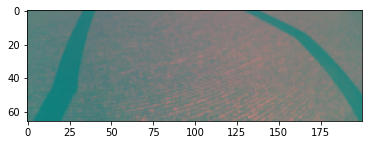

In [14]:
test_image_paths = [
    "train_data_generation/data/drive_with_keypress/30/frame_000508_47.png",
    "train_data_generation/data/drive_with_keypress/30/frame_000400_58.png",
    "train_data_generation/data/drive_with_keypress/31/frame_000071_69.png",
    "train_data_generation/data/drive_with_keypress/30/frame_000866_72.png",
    "train_data_generation/data/drive_with_keypress/30/frame_000277_81.png",
    "train_data_generation/data/drive_with_keypress/28/frame_000017_90.png",
    "train_data_generation/data/drive_with_keypress/31/frame_000005_107.png",
    "train_data_generation/data/drive_with_keypress/30/frame_000160_113.png",
    "train_data_generation/data/drive_with_keypress/30/frame_000102_131.png",
    "train_data_generation/data/drive_with_keypress/30/frame_000125_135.png",
]
image = my_imread(test_image_paths[4])
proc_image = np.asarray([img_preprocess(image)])
plt.imshow(proc_image[0])


In [15]:
for image_path in test_image_paths:
    image = my_imread(image_path)
    proc_image = np.asarray([img_preprocess(image)])

    print(image_path)
    print(predict_with_keras(keras_model, proc_image))
    print(predict_with_tflite(tflite_model_path, proc_image))
    print(predict_with_edgetpu(edgetpu_model_path, proc_image))
    print("--------------------------------")


train_data_generation/data/drive_with_keypress/30/frame_000508_47.png
[51.432484]
[51.47842169]
[51.47842169]
--------------------------------
train_data_generation/data/drive_with_keypress/30/frame_000400_58.png
[58.292503]
[58.54408741]
[58.54408741]
--------------------------------
train_data_generation/data/drive_with_keypress/31/frame_000071_69.png
[76.43961]
[76.71294212]
[76.71294212]
--------------------------------
train_data_generation/data/drive_with_keypress/30/frame_000866_72.png
[75.36463]
[75.70356131]
[75.70356131]
--------------------------------
train_data_generation/data/drive_with_keypress/30/frame_000277_81.png
[81.84426]
[81.75984621]
[81.75984621]
--------------------------------
train_data_generation/data/drive_with_keypress/28/frame_000017_90.png
[86.32479]
[86.30205989]
[86.30205989]
--------------------------------
train_data_generation/data/drive_with_keypress/31/frame_000005_107.png
[103.46934]
[103.46153378]
[103.46153378]
--------------------------------
